# Assignment 3: Landing the rocket
## Y2 Computing (2020&ndash;21), weeks 9&ndash;11

In this assignment you are given a uniquely designed rocket ship, represented by a `Rocket` object, and tasked with landing the rocket on a platform floating in the sea. The tasks will lead you through a sequence of steps designed for you to get to know your rocket and to learn how to control it. 

To start, please enter your student ID into the cell below. Your rocket will be generated from your student ID such that no two different IDs will ever create the same rocket.

In [1]:
# Do not alter any of the code within this cell other than the value of studentID
import numpy as np
import matplotlib.pyplot as plt
# Setting global plotting settings
plt.rcParams['font.size'] = 20
plt.rcParams['axes.formatter.useoffset'] = False
from module_engine.assignment import Rocket

# Enter your student ID here
studentID = 0

# Your Rocket object to be used throughout this assignment
my_rocket = Rocket(studentID)  

*** Using a temporary ID. Switch to your own ID as soon as possible. ***



## Introduction
For your new assignment, you have been drafted to help with the rocket development at Space-Z. The executives at Space-Z have been watching many rocket booster landings on Youtube recently and are now pushing for their engineering team to achieve vertical landings for their rockets. Your task will be to develop a simple feedback-control system for the horizontal thrusters to allow the rocket to land on a floating platform. However before you can do that, you will need to familiarise yourself with your rocket and calibrate the thrusters.

For simplicity, we will work in two-dimensional space: the **x** coordinate determines the horizontal position of the rocket, while the **y** coordinate determines its altitude above sea level.

### Your rocket
You can interact with your rocket by calling methods of the `my_rocket` object. 

Real-time interaction:
 - You can apply horizontal thrust by using the **advance** method: `.advance(left_thrust, right_thrust)` will apply `left_thrust` and `right_thrust` during a time interval which is always **1/60 s long**. The function returns a NumPy array with three values. The first two values are the **x** and **y** positions of the rocket. If the third value is not 0, the rocket has left the simulated space and has to be reset, see below. The simulation does not continue outside of the `advance` method. Therefore, by calling the `advance` method repeatedly, you can perform a flight or landing simulation step-by-step.
 
Utility functions:
 - `.reset('space'/'drop')` returns your rocket to its starting position and initial conditions. The reset function can be called with the parameters `space` to perform tests without gravity, or `drop` to attempt landings on the floating platform.
 - `.get_platform_pos()` returns the current **x** position of the floating platform.
 - `.get_flight_data()` can be called **after** a completed simulation, it returns the data recorded during the flight in the form of a two-dimensional NumPy array, with each row being an array of three values: `[t, x, y]`. Here `x` and `y` refer to the rocket position at a time `t` after the start of the flight.

## Training space

This is our first attempt at moving our rocket around. We are putting it into a training space by called `.reset('space')` to start. Then we use  `while` loops to call the `.advance` function repeatedly. Afterwards we request the flight data and plot the recorded rocket positions. Note that we must use the **left** thruster to move to the right (towards potitive x values), and **right** thruster to move to the left.

In [2]:
N = 0           # Step counter
Nmax = 300      # Number of tracking steps of 1/60 s duration
thrust = 2000.0 # A random test thrust

my_rocket.reset('space')
# Apply right thrust for a while
while N<Nmax:
    N+=1 #N = N+1
    pos = my_rocket.advance(0.0,thrust)
# Now apply left thrust
N=0
while N<2*Nmax:
    N+=1
    pos = my_rocket.advance(thrust,0.0)
# Apply right thrust again
N=0
while N<Nmax:
    N+=1
    pos = my_rocket.advance(0.0,thrust)

track = my_rocket.get_flight_data()

In [3]:
track

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.66666667e-02, -1.69476600e-04,  0.00000000e+00],
       [ 3.33333333e-02, -5.08429700e-04,  0.00000000e+00],
       ...,
       [ 1.99666667e+01,  8.82127593e+00,  0.00000000e+00],
       [ 1.99833333e+01,  8.83618467e+00,  0.00000000e+00],
       [ 2.00000000e+01,  8.85092392e+00,  0.00000000e+00]])

Now we can plot the x position of the rocket:

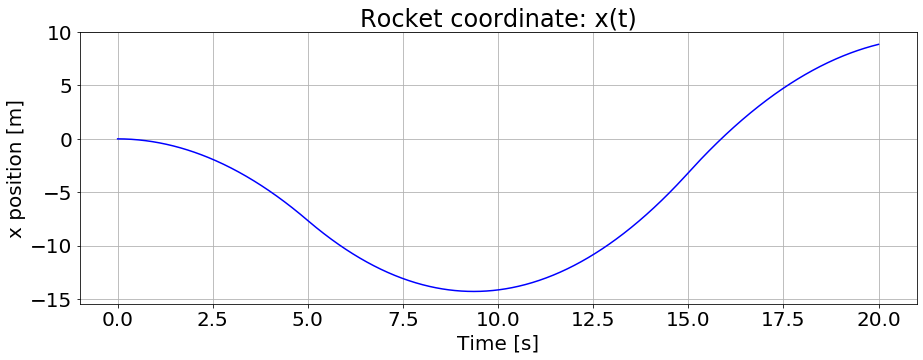

In [4]:
t=track[:,0]
x=track[:,1]
y=track[:,2]

# Plot the x-position as a function of time
fig = plt.figure(figsize=(15,5))
ax = plt.plot(t, x, 'b-')
plt.title('Rocket coordinate: x(t)') 
plt.xlabel('Time [s]') 
plt.ylabel('x position [m]')
plt.grid()
plt.show()

From the position information we can compute the horizontal velocity and acceleration:

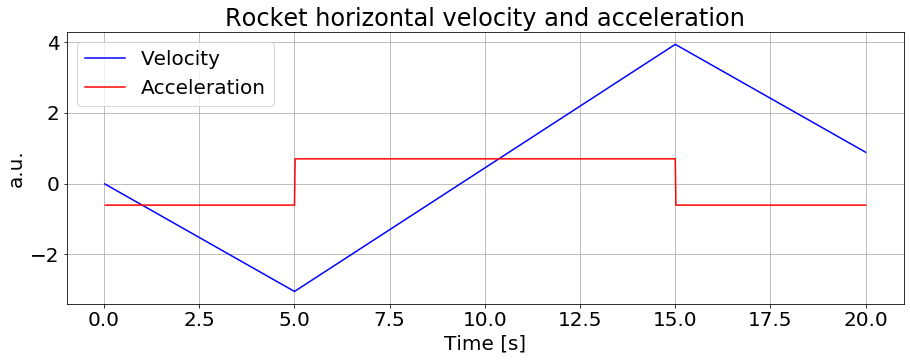

In [5]:
# Compute the speed and acceleration of our rocket
v = np.diff(x)/np.diff(t)
a = np.diff(v)/np.diff(t)[1:]


fig = plt.figure(figsize=(15,5))
# Plot velocity and acceleration as a function of time
plt.plot(t[1:],v, 'b-', label='Velocity')
plt.plot(t[2:],a, 'r-', label='Acceleration')
plt.title('Rocket horizontal velocity and acceleration') 
plt.xlabel('Time [s]') 
plt.ylabel('a.u.')
plt.grid()
plt.legend()
plt.show()

## Calibration
We can see from the above test that we need to calibrate the rocket thrusters. We used the same numerical value for the input arguments `left_thrust` and `right_thrust` in `advance`, however the result shows different numerical values for the resulting acceleration. This means that the actual thrust is not equal to the numerical value requested via the `advance` function. Let's assume that the acceleration of the rocket from the thrust $F$ requested from each thruster is given by the following formula:

$$a(F) = \left\{\begin{align}(F-F_0)/m& \qquad \text{for} ~~~ 0<F-F_0<F_{\rm max};\\
F_{\rm max}/m & \qquad \text{for} ~~~ F-F_0\ge F_{\rm max};\\
0 & \qquad {\rm for} ~~~ F\le F_0.
\end{align}\right.$$

Here
 - $F>0$ is the requested thrust [N];
 - $F_0>0$ is an offset between requested thrust and applied thrust [N];
 - $F_{\rm max}>0$ is a maximum level for achievable thrust [N];
 - $m$ is the mass of the rocket [kg].

The offset parameter $F_0$ is different for each of the two thrusters, while the maximum thrust parameter $F_{\rm max}$ is equal for the two thrusters. The numerical values of the parameters $F_0$, $F_{\rm max}$ and $m$ are unknown.

# Task 1: System identification
#### Marks available:  8

In this task you are asked to use the `space` mode with your rocket to calibrate your thrusters. Please perform one or several experiments with your rocket to find the offset value $F_0$ for each thruster, as well as the values of the maximum thrust $F_{\rm max}$ and the rocket mass $m$. This is another example of *system identification* encountered in assignment 2, however we can use the time domain data directly without considering the frequency domain.

Interact with your rocket to obtain the numerical values for $F_0$, $F_{\rm max}$ and $m$ with the following accuracy:
 - rocket mass $m$: within 1 kg;
 - offets for the left and right thrusters, $F_0^{\rm left}$ and $F_0^{\rm right}$: within 1 N;
 - maximum thrust $F_{\rm max}$: within 10 N.

In [6]:
# Student code to experiment with the rocket
# First experiment: calculate thrust offsets


# Left : 

N = 0           # Step counter
Nmax = 300      # Number of tracking steps of 1/60 s duration
thrust = 0 # thrust counter
thrustMax = 1000 # thrust counter

my_rocket.reset('space')
# Apply right thrust for a while
while thrust<thrustMax:
    thrust+=1
    pos = my_rocket.advance(thrust,0.0)

track = my_rocket.get_flight_data()


'''
# Right : 

N = 0           # Step counter
Nmax = 300      # Number of tracking steps of 1/60 s duration
thrust = 0 # thrust counter
thrustMax = 10000 # thrust counter

my_rocket.reset('space')
# Apply right thrust for a while
while thrust<thrustMax:
    thrust+=1
    pos = my_rocket.advance(0.0,thrust)

track = my_rocket.get_flight_data()
'''



"\n# Right : \n\nN = 0           # Step counter\nNmax = 300      # Number of tracking steps of 1/60 s duration\nthrust = 0 # thrust counter\nthrustMax = 10000 # thrust counter\n\nmy_rocket.reset('space')\n# Apply right thrust for a while\nwhile thrust<thrustMax:\n    thrust+=1\n    pos = my_rocket.advance(0.0,thrust)\n\ntrack = my_rocket.get_flight_data()\n"

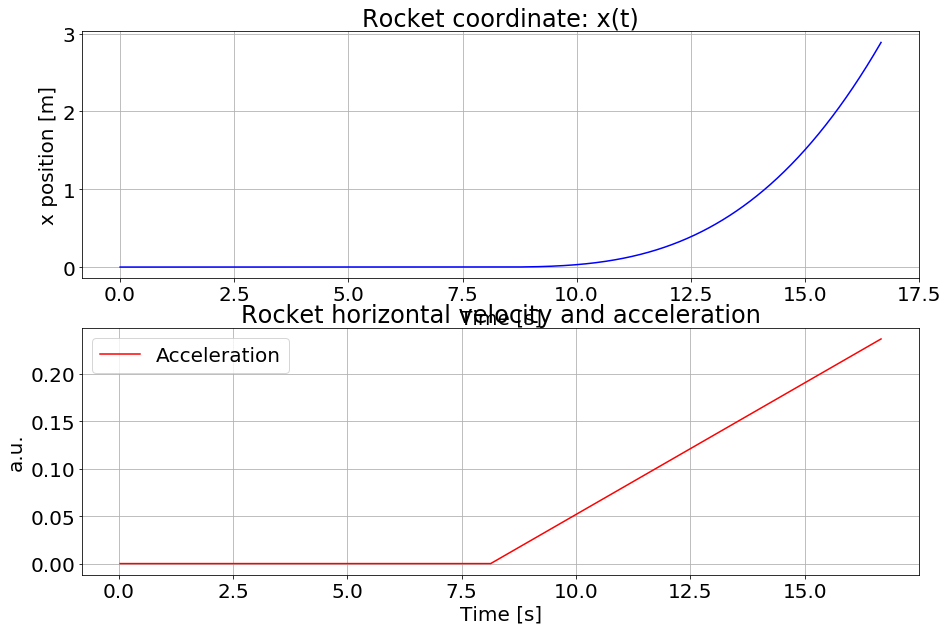

In [7]:
t=track[:,0]
x=track[:,1]
y=track[:,2]

# Compute the speed and acceleration of our rocket
v = np.diff(x)/np.diff(t)
a = np.diff(v)/np.diff(t)[1:]

# Plot the x-position as a function of time
fig = plt.figure(figsize=(15,10))
plt.subplot(211)
ax = plt.plot(t, x, 'b-')
plt.title('Rocket coordinate: x(t)') 
plt.xlabel('Time [s]') 
plt.ylabel('x position [m]')
plt.grid()
#plt.show()

plt.subplot(212)
# Plot velocity and acceleration as a function of time
#plt.plot(t[1:],v, 'b-', label='Velocity')
plt.plot(t[2:],a, 'r-', label='Acceleration')
plt.title('Rocket horizontal velocity and acceleration') 
plt.xlabel('Time [s]') 
plt.ylabel('a.u.')
plt.grid()
plt.legend()
plt.show()

In [8]:
#a
index=np.argmin(np.abs(a-0.00044064))

In [9]:
index=np.argmin(np.abs(a-0.00044064))
#index=np.argmin(np.abs(a+0.00025092))

print(index)
print(t[index])
#a
#F0 left = 487
#F0 right = 678

487
8.1166666667


In [10]:
# Second experiment: calculate the mass
# (F-F0) / m for medium regime 

index_bis = 622
print(t[index_bis])
print(a[index_bis])
# F-F0 / 0.08064220263091566 = m 
# F = 853
# f0 = 678
print((index_bis+1-487)/ (a[index_bis]))

10.3666666667
0.06281277431745473
2165.164673552839


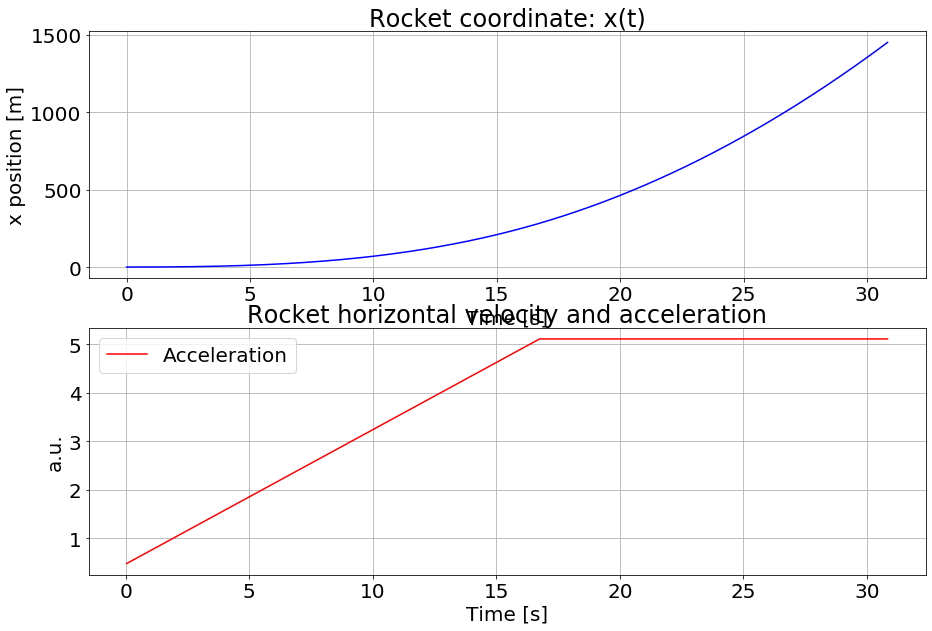

In [11]:
# Third experiment: calculate the maximum thrust

N = 0           # Step counter
Nmax = 300      # Number of tracking steps of 1/60 s duration
thrust = 1500 # thrust counter
thrustMax = 20000 # thrust counter

my_rocket.reset('space')
# Apply right thrust for a while
thrust_tracking=[]
while thrust<thrustMax:
    thrust_tracking.append(thrust)
    thrust+=10
    pos = my_rocket.advance(thrust,0.0)

track = my_rocket.get_flight_data()

t=track[:,0]
x=track[:,1]
y=track[:,2]

# Compute the speed and acceleration of our rocket
v = np.diff(x)/np.diff(t)
a = np.diff(v)/np.diff(t)[1:]

# Plot the x-position as a function of time
fig = plt.figure(figsize=(15,10))
plt.subplot(211)
ax = plt.plot(t, x, 'b-')
plt.title('Rocket coordinate: x(t)') 
plt.xlabel('Time [s]') 
plt.ylabel('x position [m]')
plt.grid()
#plt.show()

plt.subplot(212)
# Plot velocity and acceleration as a function of time
#plt.plot(t[1:],v, 'b-', label='Velocity')
plt.plot(t[2:],a, 'r-', label='Acceleration')
plt.title('Rocket horizontal velocity and acceleration') 
plt.xlabel('Time [s]') 
plt.ylabel('a.u.')
plt.grid()
plt.legend()
plt.show()



In [14]:
index=np.argmin(np.abs(a-5.10903586))
import sys
np.set_printoptions(threshold=sys.maxsize)
#a
print(index)
print(a[index])
print(t[index])
print(thrust_tracking[index]-o_left)
#11058.105469

1003
5.10903585733671
16.7166666667
11043


In [15]:
# Enter the results from your experiments into the variables below.
# You may type the numerical values with the requested accuracy,
# or you can assign these variables to another variable computed above.
# Do not change the names of the variables.
o_left = 487
o_right = 678
m = 2165
tmax = 11043

## Task 2: There and stop
#### Marks available:  2

Knowing the thruster calibration, we can move the rocket around in a more precise fashion.

### Using the thruster calibration 
First write two utility functions that make use of the known thruster calibration to compute the thrust required to provide a certain acceleration to the rocket. Each function should accept a NumPy array and return a NumPy array (both of float values).

In [16]:
# Add functions here (do not change the function names!)
def acc2thrust_left(acceleration):
    thrust = (acceleration + (o_left/m))*m
    return thrust

def acc2thrust_right(acceleration):
    thrust = (acceleration + (o_right/m))*m
    return thrust

Please test these functions by applying a known acceleration to the rocket, and comparing it to the measured acceleration. This test will not be marked. However you can lose marks in this and the following tasks if the functions are not implemented exactly as requested. Hint: after doing an experiment that uses your utility functions, make a plot that shows the difference between the requested and the measured acceleration. For thrusts below the maximum value, the absolute acceleration errors should be well below 0.001.

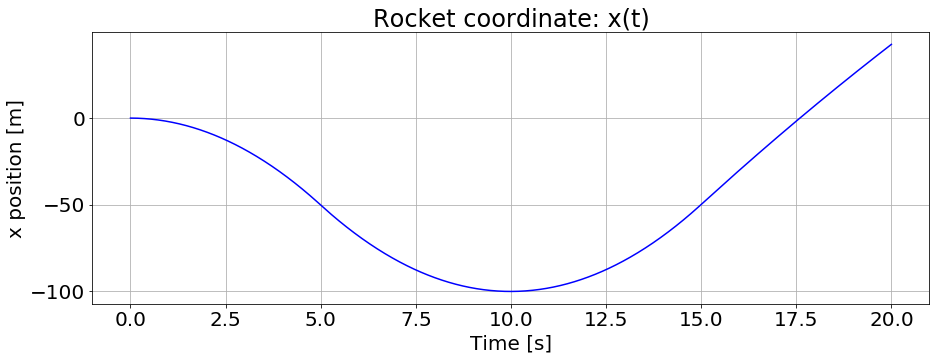

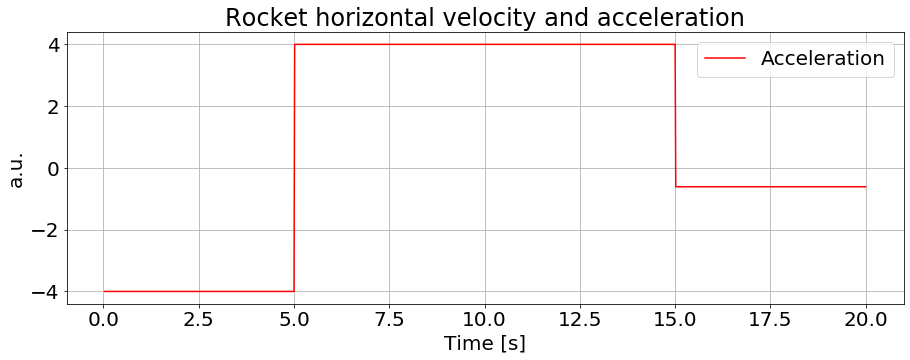

In [17]:
N = 0           # Step counter
Nmax = 300      # Number of tracking steps of 1/60 s duration
thrust = 2000.0 # A random test thrust

my_rocket.reset('space')
# Apply right thrust for a while
while N<Nmax:
    N+=1
    pos = my_rocket.advance(0.0,acc2thrust_right(4))
# Now apply left thrust
N=0
while N<2*Nmax:
    N+=1
    pos = my_rocket.advance(acc2thrust_left(4),0.0)
# Apply right thrust again
N=0
while N<Nmax:
    N+=1
    pos = my_rocket.advance(0.0,thrust)

track = my_rocket.get_flight_data()

t=track[:,0]
x=track[:,1]
y=track[:,2]

# Plot the x-position as a function of time
fig = plt.figure(figsize=(15,5))
ax = plt.plot(t, x, 'b-')
plt.title('Rocket coordinate: x(t)') 
plt.xlabel('Time [s]') 
plt.ylabel('x position [m]')
plt.grid()
plt.show()

# Compute the speed and acceleration of our rocket
v = np.diff(x)/np.diff(t)
a = np.diff(v)/np.diff(t)[1:]


fig = plt.figure(figsize=(15,5))
# Plot velocity and acceleration as a function of time
#plt.plot(t[1:],v, 'b-', label='Velocity')
plt.plot(t[2:],a, 'r-', label='Acceleration')
plt.title('Rocket horizontal velocity and acceleration') 
plt.xlabel('Time [s]') 
plt.ylabel('a.u.')
plt.grid()
plt.legend()
plt.show()

### Moving the rocket with a pre-calculated control sequence
Now make use of your utility functions to move your rocket horizontally in a space without gravity from a starting point with a horizontal coordinate **x=0** to a final point with **x=100 m**. The rocket should stop at the final point. More specifically, the task is to: 
- end the flight at a coordinate within 1 m of the target point;
- make sure the rocket **x** coordinate never exceeds 101 m;
- end the flight with the rocket speed not exceeding 0.1 m/s;
- achieve a total flight time below 30 s.

Do not forget to reset your rocket at the start of the code. You are not supposed to use any algorithm to compute the thrust in real time. A full control sequence, in terms of the thrust value at each time step, should be hard-coded in before the flight.

The marking script will evaluate your track data, recorded in the cell below the next. Make sure that the track data contains the full flight path. Please plot your track to check at least that you arrive at the correct final position witin the time allowed.

In [18]:
# Your code for 'there and stop'
N = 0           # Step counter
Nmax = 1800      # Number of tracking steps of 1/60 s duration

my_rocket.reset('space')
# Now apply left thrust
N=0
for i in range(int(Nmax/2)):
    pos = my_rocket.advance(acc2thrust_left(0.445),0.0)
    
for i in range(int(Nmax/2),Nmax):
    pos = my_rocket.advance(0.0,acc2thrust_right(0.445))
    
    


In [19]:
# The following records the track data to be marked.
# Make sure you call reset() before, but not during or after your flight!
student_track1 = my_rocket.get_flight_data()

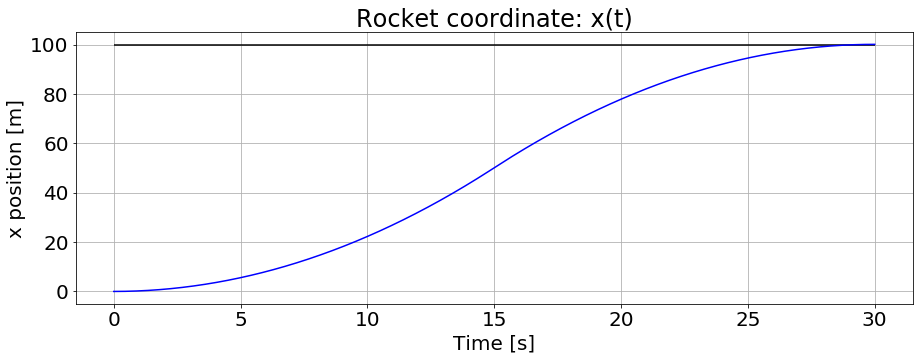

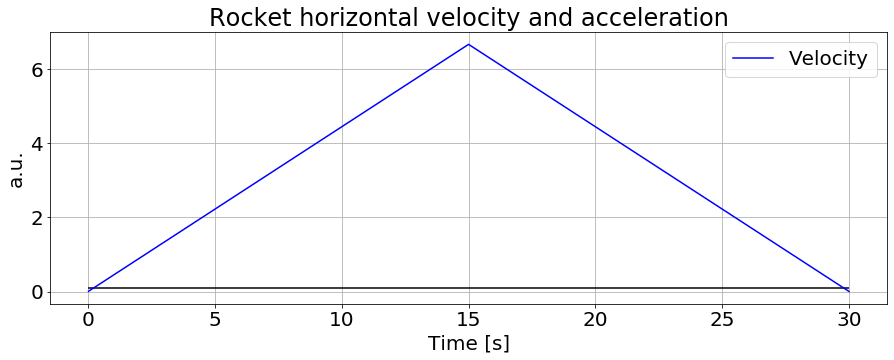

In [20]:
# Cell for plotting the track to check results

track = my_rocket.get_flight_data()


t=track[:,0]
x=track[:,1]
y=track[:,2]

# Plot the x-position as a function of time
fig = plt.figure(figsize=(15,5))
ax = plt.plot(t, x, 'b-')
plt.hlines(100,0,30)
plt.title('Rocket coordinate: x(t)') 
plt.xlabel('Time [s]') 
plt.ylabel('x position [m]')
plt.grid()
plt.show()

# Compute the speed and acceleration of our rocket
v = np.diff(x)/np.diff(t)
a = np.diff(v)/np.diff(t)[1:]

fig = plt.figure(figsize=(15,5))
# Plot velocity and acceleration as a function of time
plt.plot(t[1:],v, 'b-', label='Velocity')
plt.hlines(.1,0,30)
#plt.plot(t[2:],a, 'r-', label='Acceleration')
plt.title('Rocket horizontal velocity and acceleration') 
plt.xlabel('Time [s]') 
plt.ylabel('a.u.')
plt.grid()
plt.legend()
plt.show()

## Task 3: Feedback control
#### Marks available:  6

In the task above, we could use our accurate knowledge of the total force acting on the rocket to determine the required thrust for the entire duration flight in advance. However the final task of landing the rocket will involve side winds and a moving platform, which makes this approach impossible. We will therefore develop a **feedback control system**. Feedback control makes use of real-time information to adjust the parameters. In our case, we will use the horizontal position of the rocket to adjust the thrust. In this task you will develop a feedback algorithm for your rocket.

### Moving there, using feedback
Your task is to move the rocket from a starting point **x=0** to a target position **x=100 m** and keep it there, but now using a feedback system.

A naive approach is to activate the left thruster if the rocket is to the left of the target, and activate the right thruster otherwise. One can set the thrust to be proportional to the distance of the rocket from the target. However this will not work in practice, as this will make the rocket oscillate around the target position. Nevertheless, let's implement an algorithm to verify this.

Write a function that accepts two input arguments: the x-position of the rocket and the target position, and returns two values: `left_thrust` and `right_thrust` to be used with `advance()` method. Your function should compute the thrust such that the rocket acceleration is proportional to the distance from the target, using a code similar to ` acc = gain * (target-pos)`. The `gain` is a scaling factor that you can adjust to control the strength of the feedback. Your function should call the `acc2thrust_left` and `acc2thrust_right` functions defined above.

In [21]:
# Student code for position-based feedback,
# do *not* change the name or arguments of the function.

def position_feedback(pos, target):
    # Your code here
    gain = .5 
    acc = gain * (target-pos)
    if pos < target : 
        left_thrust = acc2thrust_left(acc)
        right_thrust = 0
    else :
        right_thrust = -acc2thrust_right(acc)
        left_thrust = 0

    return left_thrust, right_thrust

In [22]:
position_feedback(101,100)

(0, 404.49999999999994)

### Oscillation
Test the `position_feedback` function by trying to move the rocket from an inintial position **x=0** to a target position **x=100 m**. Adjust the `gain` parameter in the `position_feedback` function such that you can clearly see the rocket oscillating around the target position during an approximately 60 s long flight. The track of your test is recorded in the cell below next. The track data stored in `student_track2` will be analysed and marked.

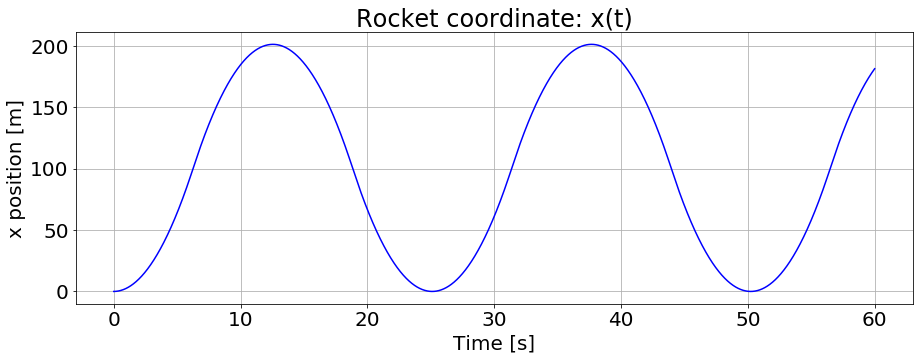

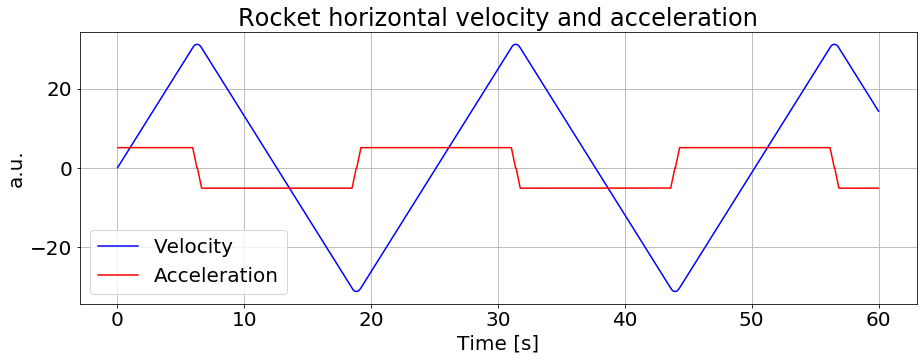

In [23]:
# Student code for creating flight path with 
# an oscillation around target

x_history=[0]
target = 100

my_rocket.reset('space')

for i in range(3600):
    current_position = x_history[-1]
    
    left,right = position_feedback(current_position,target)
    
    pos = my_rocket.advance(left,right)
    x_history.append(pos[0])

track = my_rocket.get_flight_data()


t=track[:,0]
x=track[:,1]
y=track[:,2]

# Plot the x-position as a function of time
fig = plt.figure(figsize=(15,5))
ax = plt.plot(t, x, 'b-')
plt.title('Rocket coordinate: x(t)') 
plt.xlabel('Time [s]') 
plt.ylabel('x position [m]')
plt.grid()
plt.show()

# Compute the speed and acceleration of our rocket
v = np.diff(x)/np.diff(t)
a = np.diff(v)/np.diff(t)[1:]

fig = plt.figure(figsize=(15,5))
# Plot velocity and acceleration as a function of time
plt.plot(t[1:],v, 'b-', label='Velocity')
plt.plot(t[2:],a, 'r-', label='Acceleration')
plt.title('Rocket horizontal velocity and acceleration') 
plt.xlabel('Time [s]') 
plt.ylabel('a.u.')
plt.grid()
plt.legend()
plt.show()
    

In [24]:
# The following records the track data to be marked, Make sure
# that you do not call `reset()` during or after your flight!
student_track2 = my_rocket.get_flight_data() 

In [25]:
# Cell for plotting the track to check results


### Damped oscillation 

The above result is not surprising: we have created a system in which a restoring force is proportional to the position (with respect to the target point). The resulting harmonic oscillator will oscillate forever around the target position. This behaviour can be changed by creating a damped oscillator that settles (quickly) at the target position. This can be achieved by using a new function that computes the feedback based on the **position** and **speed** of the rocket.

Write a new feedback function to compute the rocket thrust. This function should accept three input arguments: position, velocity and target position. Internally it should use two gain values, a position gain `pos_gain` and a velocity gain `v_gain`, and return the thrust values as before. 

Adjust the two gains such that the rocket reaches its target quickly and does not overshoot the target by more than 1 meter at any time. Perform a flight and record the track data in the cells below. The track data stored in `student_track3` will be analysed and marked.

In [42]:
# Student code for position and velocity feedback,
# do *not* change the name or arguments of the function.


def damped_feedback(pos, v, target):
    # Your code here
    pos_gain=1000
    v_gain=2250
    
    acc = pos_gain* (target-pos) - v_gain*v
    left_thrust = 0
    right_thrust = 0
    
    if acc > 0: 
        left_thrust = acc2thrust_left(np.abs(acc))
    if acc < 0:
         right_thrust = acc2thrust_right(np.abs(acc))
   
    return left_thrust, right_thrust



In [43]:
# Student code to create flight track with damped oscillation
    
x_history=[0]
v_history=[0]
target = 100
t = 1/60

my_rocket.reset('space')

for i in range(3600):
    current_position = x_history[-1]
    current_speed = v_history[-1]
    
    left,right = damped_feedback(current_position,current_speed,target)
    pos = my_rocket.advance(left,right)
    x_history.append(pos[0])
    v_history.append( (x_history[-1] - x_history[-2]) / t)
    


In [44]:
# The following records the track data to be marked, Make sure
# that you do not call `reset()` during or after your flight!
student_track3 = my_rocket.get_flight_data() 

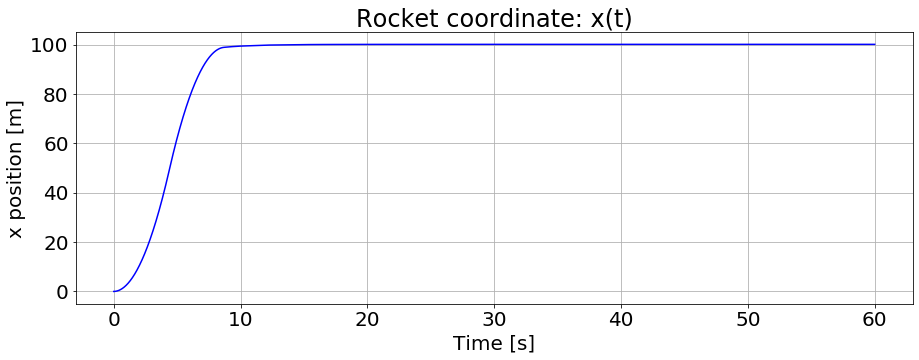

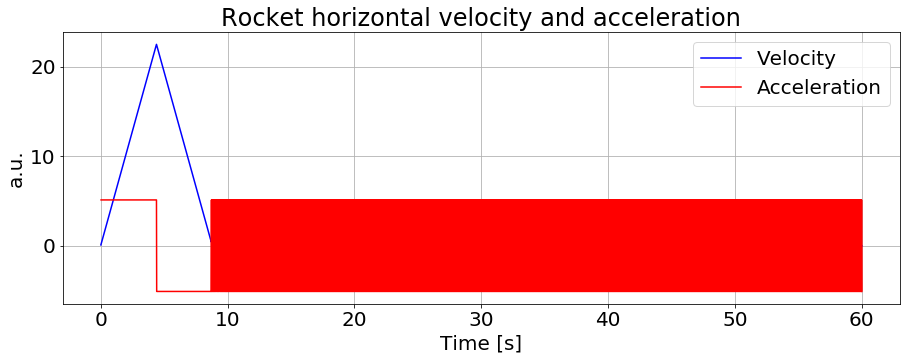

In [45]:
# Cell for plotting the track to check results

track = my_rocket.get_flight_data()


t=track[:,0]
x=track[:,1]
y=track[:,2]

# Plot the x-position as a function of time
fig = plt.figure(figsize=(15,5))
ax = plt.plot(t, x, 'b-')
plt.title('Rocket coordinate: x(t)') 
plt.xlabel('Time [s]') 
plt.ylabel('x position [m]')
plt.grid()
plt.show()

# Compute the speed and acceleration of our rocket
v = np.diff(x)/np.diff(t)
a = np.diff(v)/np.diff(t)[1:]

fig = plt.figure(figsize=(15,5))
# Plot velocity and acceleration as a function of time
plt.plot(t[1:],v, 'b-', label='Velocity')
plt.plot(t[2:],a, 'r-', label='Acceleration')
plt.title('Rocket horizontal velocity and acceleration') 
plt.xlabel('Time [s]') 
plt.ylabel('a.u.')
plt.grid()
plt.legend()
plt.show()


## Task 4: Finally, landing the rocket
#### Marks available:  4

We have finally arrived at the real challenge: your rocket starts at **y=2000 m** above the sea level, and your goal is to land it on a floating platform in the sea. Your rocket now operates in a 2D space with **x** being the position along the sea surface, and **y** being the height of the rocket above the sea level.

The platform will change location between each run (upon calling `.reset('drop')`), and might also float sideways during he rocket's descent. The **(x,y)** coordinates of the centre of the platform at any time can be obtained using `my_rocket.get_platform_pos()`. These coordinates should be your target. The horizontal size of the platform is **20 m**, therefore a landing will be deemed successful if the rocket arrives at the sea level within **±10 m** of the centre of the platform. 

The rocket will be accelerated by gravity. In addition, it will be subject to atmospheric drag which lessens the downward acceleration. More importantly side winds will result in unpredictable horizontal forces. However you are already well equipped with the feedback control system from the previous task, which should handle wind and moving targets without any further adjustments.

In this task you must switch the rocket to landing mode by always using `reset('drop')`.

Please write a loop to attempt **40 landings**. The number of successful landings will be recorded automatically. It might be difficult to succeed in 100% of your attempts. Full marks will be awarded for successful landing in 70% of the attemts.

At the start of the next cell you may call `my_rocket.reset_flight_counter()` to start counting flights from the 0 before looping over the 40 test landings. **Make sure that you use the variable `tracks` to store all your flight paths (as prepared in the while-loop below), because this variable will be used for marking.**

In [48]:
# Student code to land rocket

my_rocket.reset_flight_counter()
Nflights=40
N=0
tracks=[]
target_history=[]
# Your code here

while N<Nflights:
    my_rocket.reset('drop')
    target = my_rocket.get_platform_pos()[0]
    target_history.append(my_rocket.get_platform_pos())
    
    x_history=[0]
    v_history=[0]
    t = 1/60

    for i in range(3600):
        current_position = x_history[-1]
        current_speed = v_history[-1]
    
        left,right = damped_feedback(current_position,current_speed,target)
        pos = my_rocket.advance(left,right)
        x_history.append(pos[0])
        v_history.append( (x_history[-1] - x_history[-2]) / t)
    

    tracks.append(my_rocket.get_flight_data())
    N+=1

The rocket lands on the platform.
1 / 1 flights have resulted in a successful landing.
Call .reset("drop") before attempting a new flight.

The rocket lands on the platform.
2 / 2 flights have resulted in a successful landing.
Call .reset("drop") before attempting a new flight.

The rocket lands on the platform.
3 / 3 flights have resulted in a successful landing.
Call .reset("drop") before attempting a new flight.

The rocket lands on the platform.
4 / 4 flights have resulted in a successful landing.
Call .reset("drop") before attempting a new flight.

The rocket lands on the platform.
5 / 5 flights have resulted in a successful landing.
Call .reset("drop") before attempting a new flight.

The rocket lands on the platform.
6 / 6 flights have resulted in a successful landing.
Call .reset("drop") before attempting a new flight.

The rocket lands on the platform.
7 / 7 flights have resulted in a successful landing.
Call .reset("drop") before attempting a new flight.

The rocket lands on 

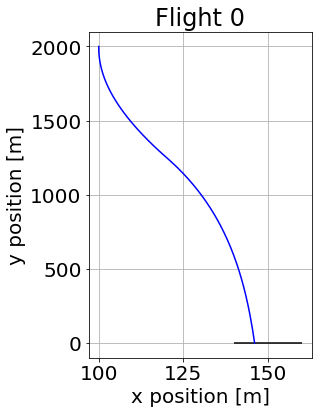

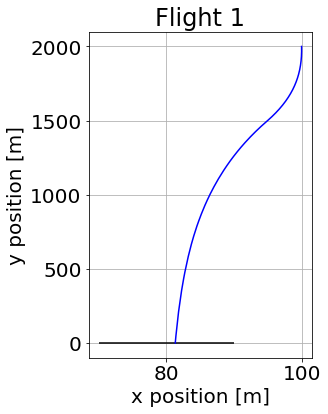

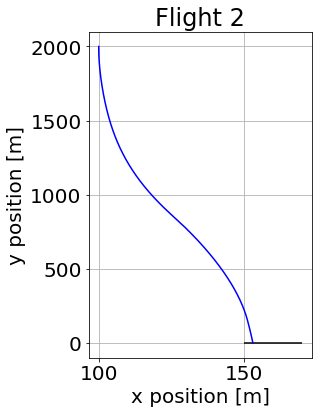

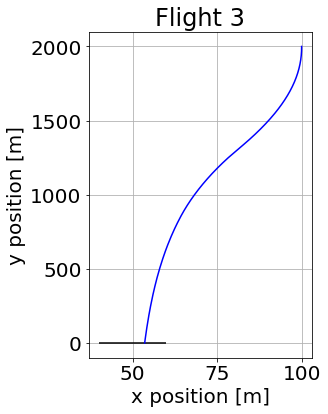

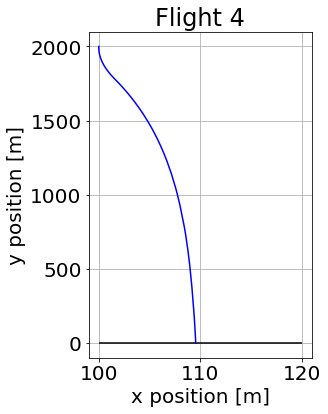

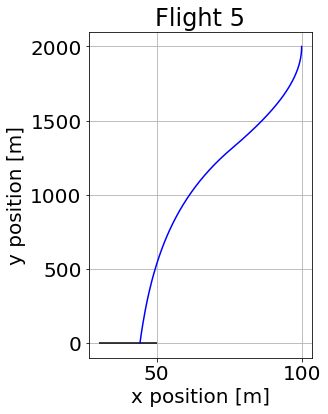

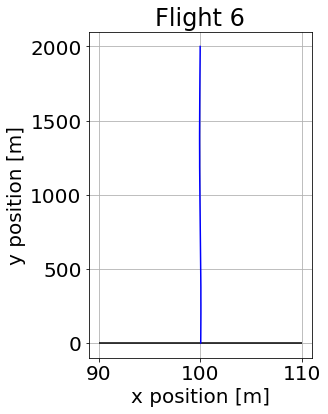

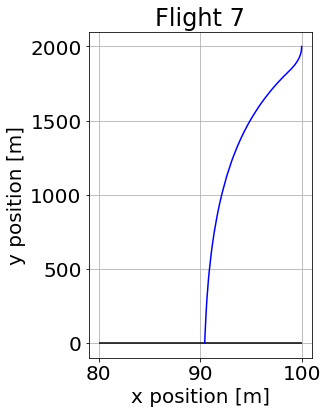

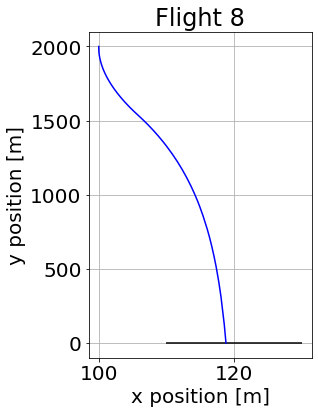

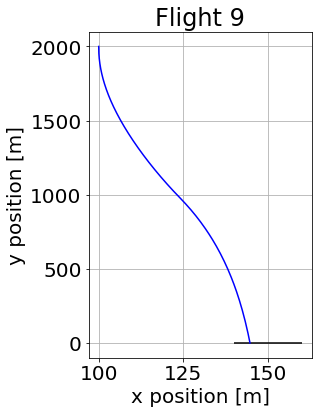

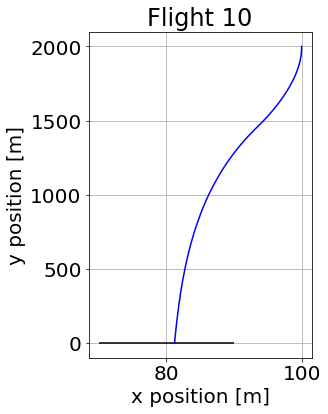

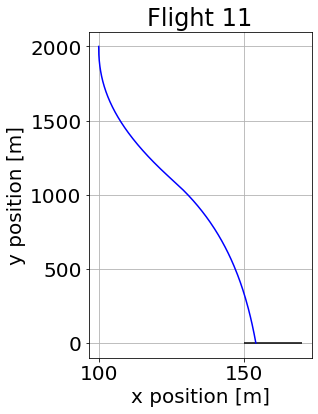

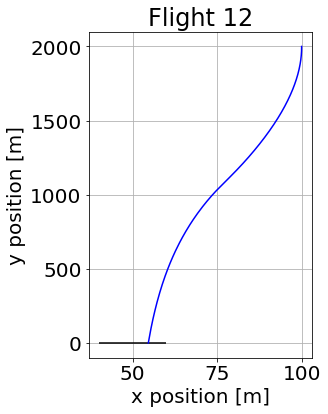

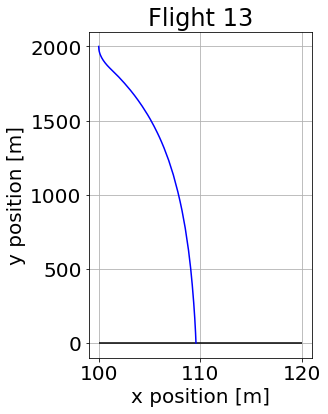

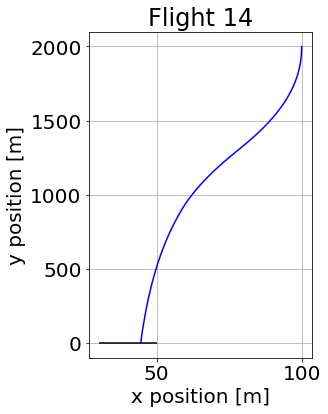

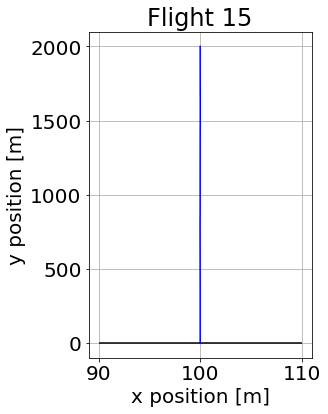

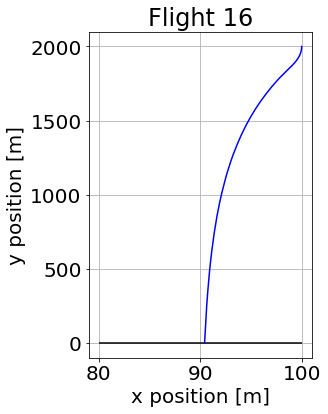

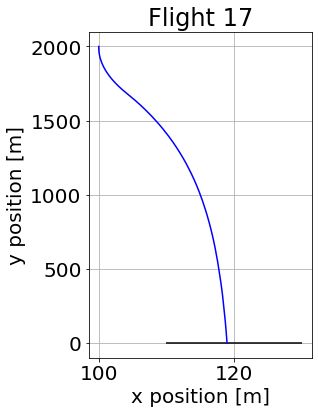

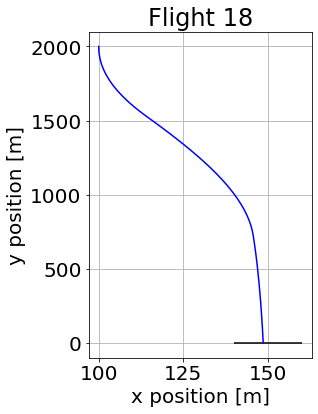

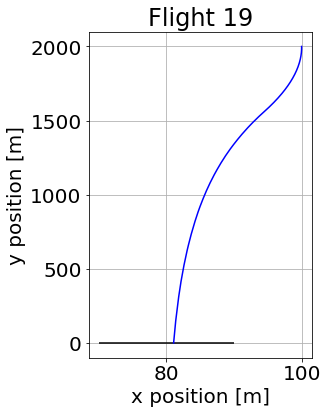

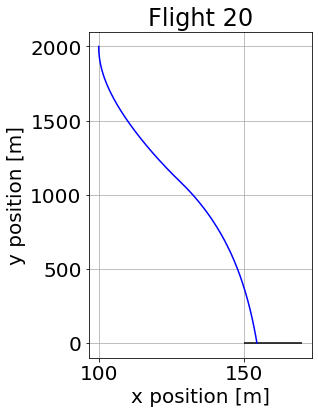

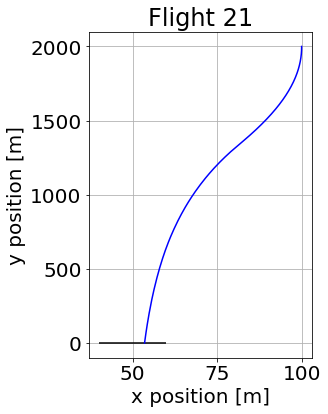

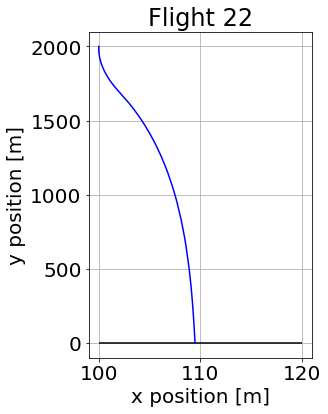

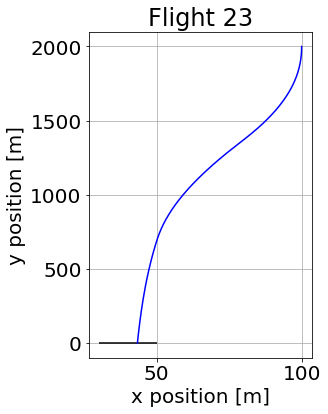

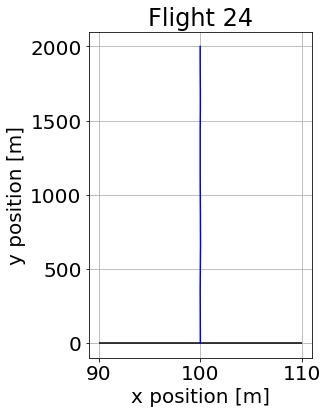

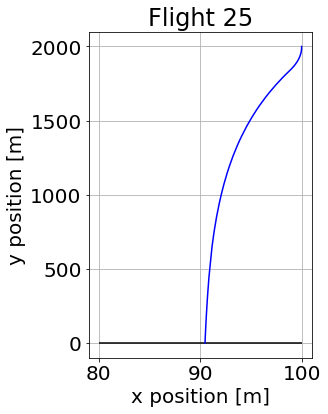

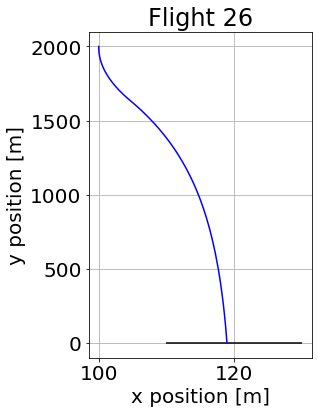

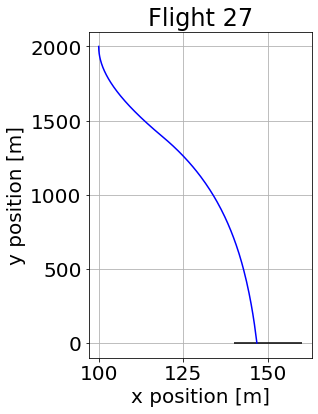

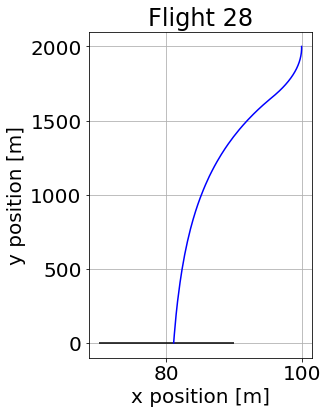

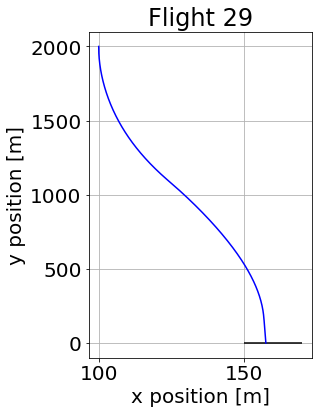

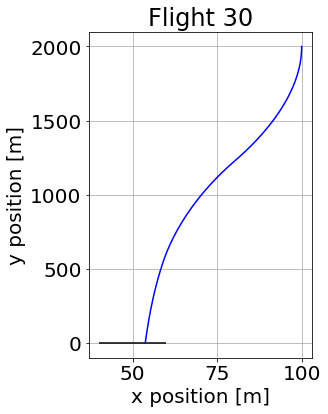

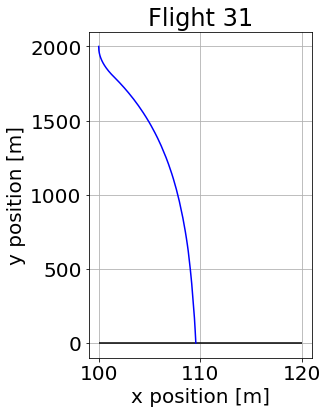

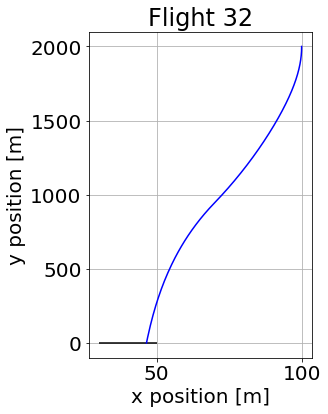

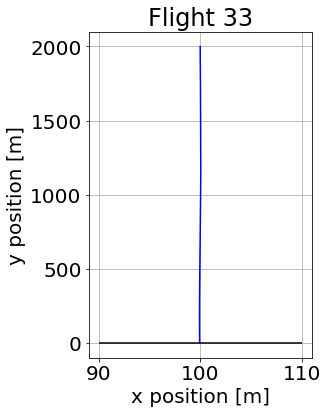

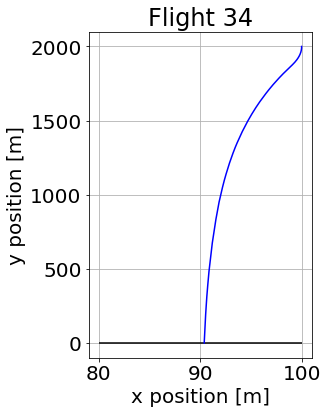

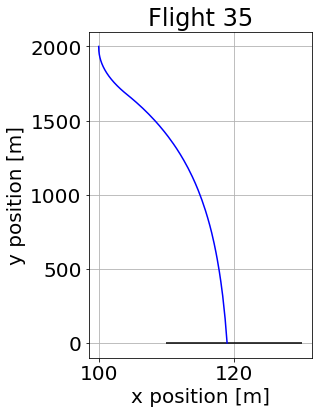

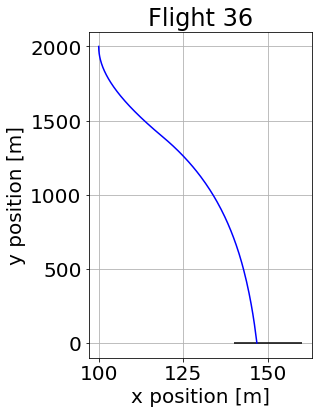

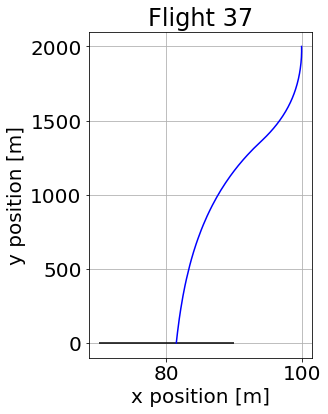

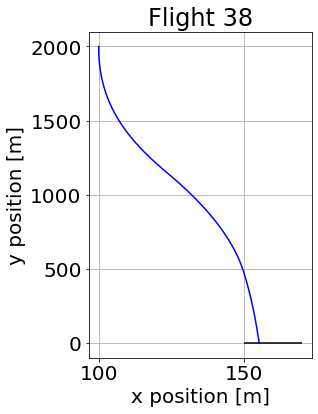

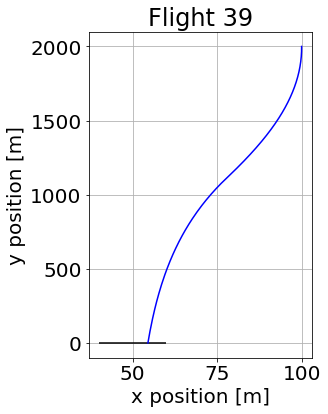

In [62]:
#flight_number=0

for flight_number in range(40):

# Student code to plot flight paths 
    t=tracks[flight_number][:,0]
    x=tracks[flight_number][:,1]
    y=tracks[flight_number][:,2]

#print(target_history[flight_number][0])

# Plot the x-position as a function of time
    fig = plt.figure(figsize=(4,6))
    ax = plt.plot(x, y, 'b-')
    plt.title('Flight ' + str(flight_number)) 
    plt.xlabel('x position [m]') 
    plt.ylabel('y position [m]')
    plt.hlines(0,target_history[flight_number][0]-10,target_history[flight_number][0]+10)
    plt.grid()
    plt.show()

In [33]:
# Check how many flights succeeded:
print(my_rocket.successful_landing_counter)

39


# For demonstrators
This example comes with the marking script included. Thus you can check your marks by exectuting the following cell. The students will not get the `marker` code and will *not* be able to do this.

In [34]:
import module_engine.marker as mark
mk=mark.Solution3(studentID)
mk.mark();

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Task 1:
 We checked if m, o_left, o_right and tmax where present in your
 notebook: 'm' was found and has the correct value, 'o_left' was found
 and has the correct value, 'o_right' was found and has the correct
 value, 'tmax' was found and has the correct value.
Score: 8/8
Task 2:
 Your notebook contains `acc2thrust_left' which returned 1 out of 1
 correct n

Marking student ID 0
*** Using a temporary ID. Switch to your own ID as soon as possible. ***



In [77]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [79]:
i=0
imax=10

while i<imax:
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9


In [1]:
o_left = 563
o_right = 477
m = 1794.2
tmax = 8281.7

In [2]:
def acc2thrust_left(acceleration):
    thrust = (acceleration*m)+o_left
    if thrust <= o_left:
        thrust = o_left
    if thrust - o_left >= tmax:
        thrust = tmax
    else:
        thrust = thrust
    return thrust

In [3]:
acc2thrust_left(4)

7739.8

In [10]:
def test(a):
    j = a + 1 
    if a>30:
        j = j +10
    else :
        j = j
    return j

In [12]:
test(2)

3